In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, image_size, class_num):
        super().__init__()
        
        self.image_size = image_size
        
        self.label_embeddings = nn.Embedding(class_num, class_num) # generate label embedding
        
        self.generator = nn.Sequential(
            nn.Linear(noise_dim + class_num, 256), # class_num = embedding size so we can add it to noise_dim for input size
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size*image_size),
            nn.Tanh(),
        )
        
    def forward(self, x, labels):
        embed = self.label_embeddings(labels)
        x = torch.cat([x, embed], dim=1)
        
        output = self.generator(x)
        return output.view(-1, self.image_size, self.image_size)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, image_size, class_num):
        super().__init__()
        
        self.label_embeddings = nn.Embedding(class_num, class_num) # generate label embedding
        self.image_size = image_size
        
        self.discriminator = nn.Sequential(
            nn.Linear(image_size*image_size + class_num, 1024), # output of generator to 1024
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            
        )
        
    def forward(self, x, labels):
        x = x.view(-1, self.image_size*self.image_size)
        
        embed = self.label_embeddings(labels)
        
        x = torch.cat([x, embed], dim=1)
        
        output = self.discriminator(x)
        
        return output.squeeze() # output originaly is (batch_size, 1) but we want to squeeze it to (batch_size,)

In [5]:
# ----- Hyperparameters ----- #
BATCH_SIZE = 64
CLASS_NUM = 10
LR = 3e-4
NOISE_DIM = 100
CRITERION = nn.BCELoss()
EPOCHS = 50
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
# ----- PIL -> Tensor + Normalization ----- #
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# ----- Import data + Create loader ----- #
dataset = datasets.FashionMNIST(root='../FashionMNIST/', transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


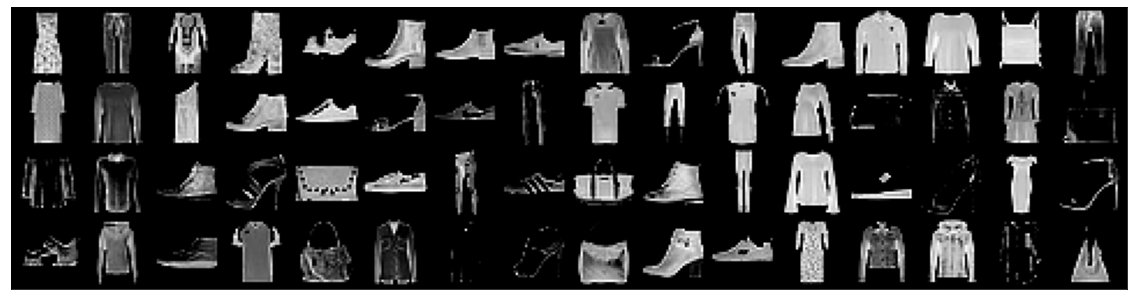

In [7]:
# ----- View Data ----- #
images, labels = next(iter(loader))
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

In [8]:
generator = Generator(NOISE_DIM, 28, CLASS_NUM).to(device)
discriminator = Discriminator(28, CLASS_NUM).to(device)

In [9]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR)

In [10]:
def generator_train_batch():
    generator_optimizer.zero_grad()
    
    noise = torch.randn(BATCH_SIZE, NOISE_DIM).to(device)
    fake_labels = torch.randint(0, CLASS_NUM, (BATCH_SIZE,)).to(device)
    
    fake_images = generator(noise, fake_labels)
    discriminator_on_fakes = discriminator(fake_images, fake_labels)
    
    generator_loss = CRITERION(discriminator_on_fakes, torch.ones_like(discriminator_on_fakes))
    generator_loss.backward()
    generator_optimizer.step()

In [11]:
def discriminator_train_batch(real_images, real_labels):
    discriminator_optimizer.zero_grad()
    
    discriminator_on_reals = discriminator(real_images, real_labels)
    discriminator_loss_on_reals = CRITERION(discriminator_on_reals, torch.ones_like(discriminator_on_reals))
    
    noise = torch.randn((BATCH_SIZE, NOISE_DIM)).to(device)
    fake_labels = torch.randint(0, CLASS_NUM, (BATCH_SIZE,)).to(device)
    fake_images = generator(noise, fake_labels)
    
    discriminator_on_fakes = discriminator(fake_images, fake_labels)
    discriminator_loss_on_fakes = CRITERION(discriminator_on_fakes, torch.zeros_like(discriminator_on_fakes))
    
    discriminator_loss = (discriminator_loss_on_reals + discriminator_loss_on_fakes)/2
    discriminator_loss.backward()
    discriminator_optimizer.step()

Epoch [10/50]


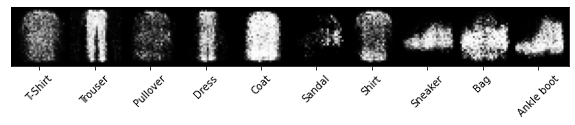

Epoch [20/50]


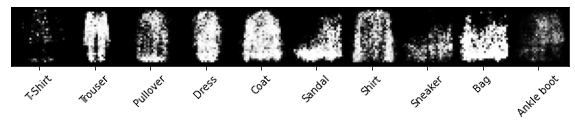

Epoch [30/50]


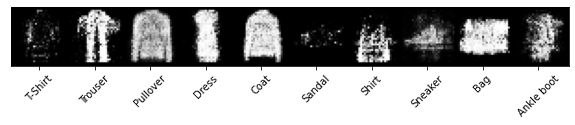

Epoch [40/50]


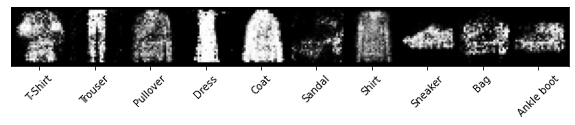

Epoch [50/50]


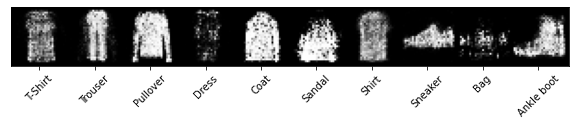

In [12]:
for epoch in range(EPOCHS):
    loop = tqdm(enumerate(loader), total=len(loader), leave=False)
    for batch_index, (images, labels) in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        discriminator.train()
        generator.train()
        
        generator_train_batch()
        discriminator_train_batch(images, labels)
        
        # ----- Update tqdm ----- #
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        
    
    # ----- Generate test images ----- #
    if (epoch+1) % 10 == 0:
        
        generator.eval()
        
        print(f"Epoch [{epoch+1}/{EPOCHS}]")
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        noise = torch.randn((10, NOISE_DIM)).to(device)
        labels = torch.tensor(np.arange(0,10)).to(device)
        
        test_images = generator(noise, labels).detach().cpu().unsqueeze(1)
        test_image_grid = make_grid(test_images, nrow=10, normalize=True).permute(1, 2, 0)
        ax.imshow(test_image_grid, cmap='gray')
        
        plt.yticks([])
        plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=10)
        plt.show()

In [48]:
# ------ Generating novel examples ----- #
def plot_new_image(labels):
    labels = torch.tensor(labels).to(device) # 1: t-shirt, 7: sneaker
    noise = torch.randn((labels.shape[0], NOISE_DIM)).to(device) # generating a noise dim for each input

    images = generator(noise,labels).unsqueeze(1) # unsqueeze since we squeezed out the channel dimension in the generator and need to add it back
    image_grid = make_grid(images, nrow=2, normalize=True).permute(1, 2, 0).to(device).detach().cpu().numpy()
    plt.imshow(image_grid, cmap='gray')
    _ = plt.yticks([]) # _ suppresses displaying the output of the function
    _ = plt.xticks(np.arange(15, 60, 30), ['T-Shirt', 'Sneaker'], rotation=45, fontsize=10)
    plt.show()

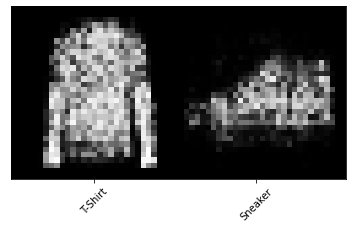

In [50]:
plot_new_image([2,7])